In [1]:
## Init Bionic VTOL
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode
create_visualization();

# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()
### Create Reinforcement Learning Environment


################################ TODO ################################
# You can initialization global constants here.
# E.g. a fixed point in the beginning of training (for testing/overfitting)
# Define global constants for initial position and rotation

#####
##### first coordinate - red axis - x
##### second coordinate - green axis - y
##### third coordinate - blue axis - z
#####

const NUM_WAYPOINTS = 2;
const INITIAL_POSITION = [0.0, 0.0, 0.0];
const INITIAL_ROTATION = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0];
const SAMPLE_WAYPOINTS = [[0.0, 0.0, 0.0], [-10.0, 0.0, 5.0]];

w_max = 25.0; # maximum rotational speed before getting punished
timeout = 15.0; # simulation end time
floor_level = -10.0; # as in aviation
v_expected = 3.0; # maximum speed before getting punished

######################################################################

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


In [2]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environments
    visualization::Bool # visualization
    realtime::Bool # realtime

    x_previous::Vector{T} # previous position
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    w_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    delta_t::T # simulation time step

    ################################ TODO ################################
    # Extend the environment here.
    # Everything you need additionaly in your environment also go in here.
    # E.g. a trajectory

    waypoints::Vector{Vector{T}} # waypoints
    proximity_tolerance::T # proximity tolerance
    v_min::T # minimum required velocity
    v_max::T # maximum allowed velocity

    ######################################################################
end


# define a keyword-based constructor for the type declared in the mutable struct typedef.
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # random number generation
    name = "vtol",
            visualization = false,
    realtime = false,
    kwargs...) # let the function take an arbitrary number of keyword arguments

    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    A = Space{Vector{ClosedInterval{T}}};

    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ],
    ) # propeller 1 and 2

    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            ################################ TODO ################################
            # Implement an observation space.
            # Here is an example space. You can change it if desired.
            # You have to extend it.
            # Orientate yourself on the observation space from the paper.

            typemin(T)..typemax(T), #1 previous position along x WORLD coordinates
            typemin(T)..typemax(T), #2 previous position along z WORLD coordinates

            typemin(T)..typemax(T), #3 current position along x WORLD coordinates
            typemin(T)..typemax(T), #4 current position along z WORLD coordinates

            typemin(T)..typemax(T), #5 orientation along x WORLD coordinates
            typemin(T)..typemax(T), #6 orientation along z WORLD coordinates

            typemin(T)..typemax(T), #7 velocity along x BODY coordinates
            typemin(T)..typemax(T), #8 velocity along y BODY coordinates

            typemin(T)..typemax(T), #9 rotational velocity along z BODY coordinates

            #changed back to world for calculating guiding path easier
            typemin(T)..typemax(T), #10 position of target along x WORLD coordinates
            typemin(T)..typemax(T), #11 position of target along z WORLD coordinates

            #changed so the drone knows the guiding path
            typemin(T)..typemax(T), #12 position of previous WP along x WORLD coordinates
            typemin(T)..typemax(T), #13 position of previous WP along z WORLD coordinates

            ######################################################################
            ],
    )

    if visualization #visualizes VTOL
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space, # action space
        state_space, # observation space
        zeros(T, length(state_space)), # current state space
        rand(action_space), # initialization action
        false, # episode done
        0.0, # time
        rng, # random number generator

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_previous, previous position
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation
        zeros(T, 3), # w_B
        zeros(T, 3), # wind_W
        T(0.02), # simulation time step

        ################################## TODO ##################################
        # Initialization everything you need additionaly in your environment here
        SAMPLE_WAYPOINTS,
        1e-5, # proximity tolerance
        1.0, # minimum required velocity
        20.0, # maximum allowed velocity
        ##########################################################################
    )

    reset!(environment)
    return environment
end;

methods(VtolEnv)


# Just for explanation:
# 1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
# 2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.'
# So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

## Define the RL interface

Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state


function computeReward(env::VtolEnv{A,T}) where {A,T}
    reward = 0.0

    ################################ TODO ################################
    # Implement the reward function.
    # Orientate on the paper.

    # Hyperparameters
    kp = 5.0;
    kw = 0.5;
    kwp = 25.0;
    kv = 1.0;
    # Stop perverse incentives
    kb = 25.0;

    # Gates and their length
    gates = [[0.0, 0.0, 0.0], [env.state[10], 0.0, env.state[11]]];
    n = length(gates);

    # closest point on the guiding path phi
    # its line-segment index lp
    x_old = [env.state[1], 0.0, env.state[2]];
    x_new = [env.state[3], 0.0, env.state[4]];
    lp_old, phi_old = calculate_progress(gates, x_old);
    lp_new, phi_new = calculate_progress(gates, x_new);

    # previous time step spt_old
    # current time step spt_new
    spt_old = 0.0;
    spt_new = 0.0;
    for i in 1:(lp_old-1)
        spt_old += (norm(gates[i+1] - gates[i]) + norm(phi_old - gates[lp_old]));
    end
    for i in 1:(lp_new-1)
        spt_new += (norm(gates[i+1] - gates[i]) + norm(phi_new - gates[lp_old]));
    end

    # rogress reward rpt at time t is as a difference in reached
    # distance between the current and previous time step
    rpt = spt_new - spt_old
    spt = spt_new

    # The sum that is later goig to be the divisor
    # for the reached distance reward
    divisor_g = 0.0;
    for i in 1:(n-1)
        divisor_g += norm(gates[i+1] - gates[i]);
    end

    # reached distance reward ks
    ks = 2 * env.v_max * env.delta_t / divisor_g;

    # waypoint index wpi must be same as the index of the current line segment
    wpi = lp_old + 1; #test
    # distance to new waypoint dw
    dwp = norm(env.x_W - gates[wpi]);
    # tolerance for proximity to a waypoint
    r_tol = env.proximity_tolerance;

    # waypoint reward rwp
    rwp = exp(-dwp/r_tol);

    # no obstacles
    collision = false;
    # terminal reward rt
    rt = collision ? -10 : 0;

    # absolute velocity
    v_vector = [env.state[7], env.state[8], 0.0]
    v = norm(v_vector);
    # rotation speed
    w = abs(env.state[9]);
    # distance from closes point on the guiding path
    gd = norm(x_new - phi_new);
    # max distance
    dmax = 0.3;

    # punishment for flying too damn fast
    rv = max(0, v - v_expected); #changed not to punish slow flight

    # Scaling factors
    svmax = v > env.v_max ? 10^(env.v_max - v) : 1.0;
    svmin = v < env.v_min ?  10^(v - env.v_min) : 1.0;
    sgd = gd > dmax  ? exp(dmax - gd) : 1.0;

    # added punishment for intentionally stopping the simulation
    bad = max(0,
        w + 1 - w_max,
        0.2* (1 + floor_level - env.x_W[3]))  * (timeout - env.t)

    # Ultimate scaling factor
    s = svmax * svmin * sgd;

    # Scaling the rewards
    kp = s * kp;
    ks = s * ks;

    reward = kp * rpt + ks * spt + kwp * rwp + rt - kw * w - kv * rv - kb * bad;

    ################################################################################################

    return reward
end

RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end

    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0) * RotY(-pi/2.0) * RotX(pi)));

    env.w_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    ################################ TODO ################################
    # Reset environment.
    # Is called if the training terminates
    # (e.g. if drone crashes or successfully reaches point)
    # HINT: Everything you added to your environment needs to be reseted.
    #       Compare it with the initialization.

    env.x_previous = [0.0; 0.0; 0.0]; # starting position
    env.delta_t = T(0.02); # Δ time

    env.waypoints = SAMPLE_WAYPOINTS;
    env.proximity_tolerance = 1e-5;


    # Visualize the waypoints
    radius = 0.1;
    visualize_waypoints(env.waypoints, radius);
    ######################################################################

    nothing
end;

# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    # flaps set to 0.0
    next_action = [a[1], a[2], 0.0, 0.0]

    _step!(env, next_action)
end

env = VtolEnv();
methods(env) # Just to explain which methods the object has


function _step!(env::VtolEnv, next_action)
# Update previous
    env.x_previous = env.x_W;

    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W);

    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);

    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0;
    torque_B[2] = 0.0;  # Body X and Y
    env.w_B[1] = 0.0;
    env.w_B[2] = 0.0;

    # integrate rigid body dynamics for delta_t
    env.x_W, env.v_B, env.R_W, env.w_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.w_B, env.t, env.delta_t, eth_vtol_param);

    if env.realtime
        sleep(env.delta_t); # just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action);
    end

    env.t += env.delta_t

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.R_W[1,1]; # orientation along x
    env.state[6] = env.R_W[3,1]; # orientation along z

    env.state[7] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[8] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[9] = env.w_B[3];  # rotational velocity along z BODY coordinates

    ################################ TODO ################################

    env.state[1] = env.x_previous[1]; # update previous x-coordinate
    env.state[2] = env.x_previous[3]; # update previous z-coordinate

    env.state[10] = env.waypoints[2][1] # position of target along x WORLD coordinates
    env.state[11] = env.waypoints[2][3] # position of target along z WORLD coordinates

    env.state[12] = env.waypoints[1][1] # position of target along x WORLD coordinates
    env.state[13] = env.waypoints[1][3] # position of target along z WORLD coordinates

    # maximum rotation speed

    env.done =
        norm(env.w_B) > w_max || # stop if body rate is too high
        norm(env.v_B) > env.v_max || # stop if body is too fast
        env.state[4] < floor_level ||
        env.t > timeout ||
        norm(env.waypoints[2] - env.x_W) < env.proximity_tolerance  # target reached
    ######################################################################

    nothing
end;

RLBase.test_runnable!(env)

# changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)
# Show an overview of the environment.

## Setup of a reinforcement learning experiment.

seed = 123
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024

    vtol_envs = [
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ];
    # define multiple environments for parallel training
    env = MultiThreadEnv(vtol_envs)

    # Define the function approximator
    # (optional) TODO: change architecture
    # TODO: research briefly what Actor Critic is
    # (optional) TODO: change optimizer
    # TODO: research what ADAM is
    ns, na = length(state(env[1])), length(action_space(env[1]))
    println(ns)
    println(na)
    approximator = ActorCritic(
                #ns - number states as input
                #3 layer; last layer splitted in mean and variance; then action is sampled
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),#
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

        agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # (optional) TODO: change eventually
        # TODO: research briefly what PPO is
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),

        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    f = joinpath("./RL_models_leo/", "vtol_2D_ppo_$t.bson") # TODO: save model here
    @save f model
    println("parameters at step $t saved to $f")
end;

function loadModel()
    f = joinpath("./RL_models_leo/", "vtol_2D_ppo_1500000.bson") # TODO: load model here
    @load f model
    return model
end;

function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")

end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  1.1s
13
2


┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
Progress:   1%|▎                                        |  ETA: 1:27:30m9m

test reward at step 10000: -1197.3325044227252


Progress:   1%|▌                                        |  ETA: 0:50:08

test reward at step 20000: -1038.7529508396442


Progress:   2%|▊                                        |  ETA: 0:37:08

test reward at step 30000: -1246.2829955078248


Progress:   2%|█                                        |  ETA: 0:30:36

test reward at step 40000: -512.8447001673078


Progress:   3%|█▎                                       |  ETA: 0:26:08

test reward at step 50000: -810.9132105775715


Progress:   4%|█▌                                       |  ETA: 0:23:52

test reward at step 60000: -486.6981606521489


Progress:   5%|█▉                                       |  ETA: 0:21:38

test reward at step 70000: -1337.0246386182575


Progress:   5%|██▎                                      |  ETA: 0:20:04

test reward at step 80000: -505.7576277216737


Progress:   6%|██▍                                      |  ETA: 0:18:53

test reward at step 90000: -796.6275399345215


Progress:   6%|██▋                                      |  ETA: 0:18:09

parameters at step 100000 saved to ./RL_models_leo/vtol_2D_ppo_100000.bson
test reward at step 100000: -1599.157016475404


Progress:   7%|██▉                                      |  ETA: 0:18:01

test reward at step 110000: -1065.3396966569037


Progress:   8%|███▎                                     |  ETA: 0:17:22

test reward at step 120000: -993.3467525948479


Progress:   9%|███▌                                     |  ETA: 0:16:46

test reward at step 130000: -868.7459682443944


Progress:   9%|███▋                                     |  ETA: 0:17:17

test reward at step 140000: -785.8268964929946


Progress:  10%|████                                     |  ETA: 0:16:59

test reward at step 150000: -619.7765239427064


Progress:  11%|████▍                                    |  ETA: 0:16:46

test reward at step 160000: -701.0046956373168


Progress:  11%|████▋                                    |  ETA: 0:16:46

test reward at step 170000: -952.1791522386694


Progress:  12%|████▉                                    |  ETA: 0:18:09

test reward at step 180000: -556.3426254486329


Progress:  12%|█████▏                                   |  ETA: 0:17:40

test reward at step 190000: -1091.3635393211264


Progress:  13%|█████▍                                   |  ETA: 0:18:35

parameters at step 200000 saved to ./RL_models_leo/vtol_2D_ppo_200000.bson
test reward at step 200000: -853.1074952868696


Progress:  14%|█████▋                                   |  ETA: 0:19:13

test reward at step 210000: -305.7729248726722


Progress:  15%|██████                                   |  ETA: 0:19:53

test reward at step 220000: -1216.1264451583263


Progress:  15%|██████▏                                  |  ETA: 0:20:14

test reward at step 230000: -582.3048781811934


Progress:  16%|██████▌                                  |  ETA: 0:20:44

test reward at step 240000: -305.82752433729496


Progress:  17%|██████▊                                  |  ETA: 0:21:09

test reward at step 250000: -625.007725755052


Progress:  17%|███████▏                                 |  ETA: 0:21:26

test reward at step 260000: -301.4917257224193


Progress:  18%|███████▎                                 |  ETA: 0:22:15

test reward at step 270000: -439.0474593939486


Progress:  18%|███████▋                                 |  ETA: 0:22:19

test reward at step 280000: -291.1990764105893


Progress:  19%|███████▉                                 |  ETA: 0:22:31

test reward at step 290000: -309.78684856498944


Progress:  20%|████████                                 |  ETA: 0:23:11

parameters at step 300000 saved to ./RL_models_leo/vtol_2D_ppo_300000.bson
test reward at step 300000: -297.3097718332196


Progress:  20%|████████▍                                |  ETA: 0:23:17

test reward at step 310000: -289.3037521006822


Progress:  21%|████████▋                                |  ETA: 0:23:23

test reward at step 320000: -410.52883492483954


Progress:  22%|█████████                                |  ETA: 0:23:20

test reward at step 330000: -669.4900395189534


Progress:  22%|█████████▏                               |  ETA: 0:23:38

test reward at step 340000: -293.74922902351034


Progress:  23%|█████████▌                               |  ETA: 0:23:40

test reward at step 350000: -284.74862530369666


Progress:  24%|█████████▊                               |  ETA: 0:23:42

test reward at step 360000: -293.6299949683434


Progress:  25%|██████████▏                              |  ETA: 0:23:42

test reward at step 370000: -275.76767050738925


Progress:  25%|██████████▍                              |  ETA: 0:24:31

test reward at step 380000: -309.020318694461


Progress:  26%|██████████▌                              |  ETA: 0:24:06

test reward at step 390000: -292.2594225864156


Progress:  26%|██████████▉                              |  ETA: 0:24:04

parameters at step 400000 saved to ./RL_models_leo/vtol_2D_ppo_400000.bson
test reward at step 400000: -281.52386239200706


Progress:  27%|███████████▏                             |  ETA: 0:24:00

test reward at step 410000: -298.9992897056305


Progress:  28%|███████████▌                             |  ETA: 0:23:55

test reward at step 420000: -311.9471675992724


Progress:  29%|███████████▊                             |  ETA: 0:24:31

test reward at step 430000: -296.87891608674477


Progress:  29%|███████████▉                             |  ETA: 0:24:08

test reward at step 440000: -424.0984039241801


Progress:  30%|████████████▎                            |  ETA: 0:24:02

test reward at step 450000: -305.8866932546402


Progress:  31%|████████████▌                            |  ETA: 0:23:54

test reward at step 460000: -306.3811357550596


Progress:  31%|████████████▉                            |  ETA: 0:23:44

test reward at step 470000: -365.6583728829827


Progress:  32%|█████████████                            |  ETA: 0:23:57

test reward at step 480000: -287.3227330115013


Progress:  32%|█████████████▎                           |  ETA: 0:23:47

test reward at step 490000: -285.81378302744116


Progress:  33%|█████████████▋                           |  ETA: 0:23:36

parameters at step 500000 saved to ./RL_models_leo/vtol_2D_ppo_500000.bson
test reward at step 500000: -287.2533245313659


Progress:  34%|█████████████▉                           |  ETA: 0:23:25

test reward at step 510000: -299.55208530978325


Progress:  35%|██████████████▎                          |  ETA: 0:23:47

test reward at step 520000: -288.76409930319505


Progress:  35%|██████████████▍                          |  ETA: 0:23:26

test reward at step 530000: -309.4157944055943


Progress:  36%|██████████████▋                          |  ETA: 0:23:15

test reward at step 540000: -348.1673438892387


Progress:  37%|███████████████                          |  ETA: 0:23:03

test reward at step 550000: -285.3389654396265


Progress:  37%|███████████████▎                         |  ETA: 0:22:50

test reward at step 560000: -288.626444347949


Progress:  38%|███████████████▌                         |  ETA: 0:22:57

test reward at step 570000: -302.0847876460862


Progress:  38%|███████████████▊                         |  ETA: 0:22:42

test reward at step 580000: -288.17687977988743


Progress:  39%|████████████████▏                        |  ETA: 0:22:29

test reward at step 590000: -293.46570326840134


Progress:  40%|████████████████▍                        |  ETA: 0:22:14

parameters at step 600000 saved to ./RL_models_leo/vtol_2D_ppo_600000.bson
test reward at step 600000: -306.2957473303757


Progress:  40%|████████████████▌                        |  ETA: 0:22:20

test reward at step 610000: -313.60309991618107


Progress:  41%|████████████████▉                        |  ETA: 0:22:04

test reward at step 620000: -305.6976008393142


Progress:  42%|█████████████████▏                       |  ETA: 0:21:49

test reward at step 630000: -293.28354921464773


Progress:  43%|█████████████████▌                       |  ETA: 0:21:35

test reward at step 640000: -291.85322086933473


Progress:  43%|█████████████████▋                       |  ETA: 0:21:39

test reward at step 650000: -539.9859798490806


Progress:  44%|██████████████████                       |  ETA: 0:21:19

test reward at step 660000: -330.2203147996896


Progress:  45%|██████████████████▎                      |  ETA: 0:21:04

test reward at step 670000: -296.10276849605594


Progress:  45%|██████████████████▌                      |  ETA: 0:20:49

test reward at step 680000: -329.8205345653035


Progress:  46%|██████████████████▊                      |  ETA: 0:20:51

test reward at step 690000: -297.24732247682607


Progress:  46%|███████████████████                      |  ETA: 0:20:34

parameters at step 700000 saved to ./RL_models_leo/vtol_2D_ppo_700000.bson
test reward at step 700000: -368.634642900835


Progress:  47%|███████████████████▍                     |  ETA: 0:20:17

test reward at step 710000: -623.5983668476264


Progress:  48%|███████████████████▋                     |  ETA: 0:20:00

test reward at step 720000: -440.5660626795307


Progress:  48%|███████████████████▉                     |  ETA: 0:19:59

test reward at step 730000: -404.4614084421256


Progress:  49%|████████████████████▏                    |  ETA: 0:19:42

test reward at step 740000: -325.6309808656399


Progress:  50%|████████████████████▌                    |  ETA: 0:19:26

test reward at step 750000: -383.70380413781123


Progress:  51%|████████████████████▊                    |  ETA: 0:19:10

test reward at step 760000: -308.5358217008225


Progress:  51%|████████████████████▉                    |  ETA: 0:19:10

test reward at step 770000: -347.0874097526751


Progress:  52%|█████████████████████▎                   |  ETA: 0:18:51

test reward at step 780000: -306.96794708073867


Progress:  53%|█████████████████████▋                   |  ETA: 0:18:33

test reward at step 790000: -327.82318044659223


Progress:  53%|█████████████████████▊                   |  ETA: 0:18:32

parameters at step 800000 saved to ./RL_models_leo/vtol_2D_ppo_800000.bson


Progress:  53%|█████████████████████▉                   |  ETA: 0:18:30

test reward at step 800000: -360.77410992826043


Progress:  54%|██████████████████████                   |  ETA: 0:18:14

test reward at step 810000: -385.16540807058493


Progress:  55%|██████████████████████▍                  |  ETA: 0:17:56

test reward at step 820000: -284.3547148959763


Progress:  55%|██████████████████████▋                  |  ETA: 0:17:38

test reward at step 830000: -290.2267982916173


Progress:  56%|██████████████████████▉                  |  ETA: 0:17:37

test reward at step 840000: -975.6726507421355


Progress:  56%|███████████████████████▏                 |  ETA: 0:17:19

test reward at step 850000: -300.5723149290503


Progress:  57%|███████████████████████▌                 |  ETA: 0:17:01

test reward at step 860000: -279.6882836761858


Progress:  58%|███████████████████████▊                 |  ETA: 0:16:42

test reward at step 870000: -293.2979867821219


Progress:  58%|███████████████████████▉                 |  ETA: 0:16:39

test reward at step 880000: -373.646996810062


Progress:  59%|████████████████████████▎                |  ETA: 0:16:20

test reward at step 890000: -353.547255334514


Progress:  60%|████████████████████████▋                |  ETA: 0:16:01

parameters at step 900000 saved to ./RL_models_leo/vtol_2D_ppo_900000.bson
test reward at step 900000: -287.0245633586159


Progress:  60%|████████████████████████▊                |  ETA: 0:15:57

test reward at step 910000: -281.4599163526231


Progress:  61%|█████████████████████████                |  ETA: 0:15:38

test reward at step 920000: -330.9677013464277


Progress:  62%|█████████████████████████▍               |  ETA: 0:15:20

test reward at step 930000: -291.54325849907025


Progress:  63%|█████████████████████████▋               |  ETA: 0:15:02

test reward at step 940000: -293.4289638695467


Progress:  63%|█████████████████████████▉               |  ETA: 0:14:58

test reward at step 950000: -292.1183606837019


Progress:  64%|██████████████████████████▏              |  ETA: 0:14:41

test reward at step 960000: -299.33925055744015


Progress:  64%|██████████████████████████▍              |  ETA: 0:14:23

test reward at step 970000: -293.69507915721033


Progress:  65%|██████████████████████████▊              |  ETA: 0:14:06

test reward at step 980000: -291.5350641727026


Progress:  66%|███████████████████████████              |  ETA: 0:13:48

test reward at step 990000: -294.14107430740586


Progress:  66%|███████████████████████████▏             |  ETA: 0:13:44

parameters at step 1000000 saved to ./RL_models_leo/vtol_2D_ppo_1000000.bson


Progress:  67%|███████████████████████████▍             |  ETA: 0:13:37

test reward at step 1000000: -1405.4282010464915


Progress:  67%|███████████████████████████▌             |  ETA: 0:13:24

test reward at step 1010000: -297.7400400847716


Progress:  68%|███████████████████████████▊             |  ETA: 0:13:06

test reward at step 1020000: -288.5057541149078


Progress:  69%|████████████████████████████▏            |  ETA: 0:12:48

test reward at step 1030000: -298.82980443771936


Progress:  69%|████████████████████████████▍            |  ETA: 0:12:29

test reward at step 1040000: -362.4382054740018


Progress:  70%|████████████████████████████▋            |  ETA: 0:12:23

test reward at step 1050000: -300.0905263195922


Progress:  70%|████████████████████████████▉            |  ETA: 0:12:04

test reward at step 1060000: -299.8725757319008


Progress:  71%|█████████████████████████████▎           |  ETA: 0:11:46

test reward at step 1070000: -1773.7851517962408


Progress:  72%|█████████████████████████████▌           |  ETA: 0:11:28

test reward at step 1080000: -1508.8248101645356


Progress:  73%|█████████████████████████████▊           |  ETA: 0:11:15

test reward at step 1090000: -287.8332229026755


Progress:  73%|██████████████████████████████           |  ETA: 0:11:02

parameters at step 1100000 saved to ./RL_models_leo/vtol_2D_ppo_1100000.bson
test reward at step 1100000: -290.5534518604674


Progress:  74%|██████████████████████████████▎          |  ETA: 0:10:44

test reward at step 1110000: -995.2420076668521


Progress:  75%|██████████████████████████████▋          |  ETA: 0:10:24

test reward at step 1120000: -295.28705669837296


Progress:  75%|██████████████████████████████▉          |  ETA: 0:10:06

test reward at step 1130000: -283.7519338522494


Progress:  76%|███████████████████████████████          |  ETA: 0:10:00

test reward at step 1140000: -1000.9546384411178


Progress:  76%|███████████████████████████████▍         |  ETA: 0:09:39

test reward at step 1150000: -291.29726189029253


Progress:  77%|███████████████████████████████▋         |  ETA: 0:09:20

test reward at step 1160000: -291.20210798221524


Progress:  78%|████████████████████████████████         |  ETA: 0:09:02

test reward at step 1170000: -300.5153421182234


Progress:  79%|████████████████████████████████▎        |  ETA: 0:08:49

test reward at step 1180000: -289.8766243415815


Progress:  79%|████████████████████████████████▍        |  ETA: 0:08:36

test reward at step 1190000: -304.48347319475704


Progress:  80%|████████████████████████████████▊        |  ETA: 0:08:17

parameters at step 1200000 saved to ./RL_models_leo/vtol_2D_ppo_1200000.bson
test reward at step 1200000: -292.2104413438931


Progress:  81%|█████████████████████████████████        |  ETA: 0:07:58

test reward at step 1210000: -734.3202119929924


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:07:51

test reward at step 1220000: -280.4239428878118


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:07:33

test reward at step 1230000: -284.83878709680295


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:07:15

test reward at step 1240000: -277.65275864969976


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:06:56

test reward at step 1250000: -288.58467598142494


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:06:38

test reward at step 1260000: -285.8182711894928


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:06:23

test reward at step 1270000: -1069.8390460129192


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:06:11

test reward at step 1280000: -275.75853331197715


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:05:53

test reward at step 1290000: -281.05412512008724


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:05:34

parameters at step 1300000 saved to ./RL_models_leo/vtol_2D_ppo_1300000.bson
test reward at step 1300000: -283.43256272472036


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:05:15

test reward at step 1310000: -278.15828388291544


Progress:  88%|████████████████████████████████████     |  ETA: 0:05:07

test reward at step 1320000: -284.8967622160238


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:04:49

test reward at step 1330000: -287.07775334906836


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:04:30

test reward at step 1340000: -276.75053134282547


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:04:11

test reward at step 1350000: -269.3930960721547


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:03:54

test reward at step 1360000: -278.5873559647574


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:03:43

test reward at step 1370000: -261.214736433941


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:03:24

test reward at step 1380000: -264.8013814956391


Progress:  93%|██████████████████████████████████████   |  ETA: 0:03:05

test reward at step 1390000: -246.27574247664242


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:02:57

parameters at step 1400000 saved to ./RL_models_leo/vtol_2D_ppo_1400000.bson


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:02:48

test reward at step 1400000: -203.40915289291127


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:02:37

test reward at step 1410000: -179.71581034679247


Progress:  95%|██████████████████████████████████████▊  |  ETA: 0:02:18

test reward at step 1420000: -169.53532624863948


Progress:  95%|███████████████████████████████████████  |  ETA: 0:01:59

test reward at step 1430000: -167.36192490721754


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:01:41

test reward at step 1440000: -164.04741925011209


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:01:31

test reward at step 1450000: -150.4595605411987


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:01:12

test reward at step 1460000: -142.43224749535142


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:53

test reward at step 1470000: -136.58891248924556


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:34

test reward at step 1480000: -128.3653464157472


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:24

test reward at step 1490000: -126.21779551486578


Progress: 100%|█████████████████████████████████████████| Time: 0:41:58


parameters at step 1500000 saved to ./RL_models_leo/vtol_2D_ppo_1500000.bson
test reward at step 1500000: -134.93352085268606


In [ ]:
agent.policy.approximator = loadModel();

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

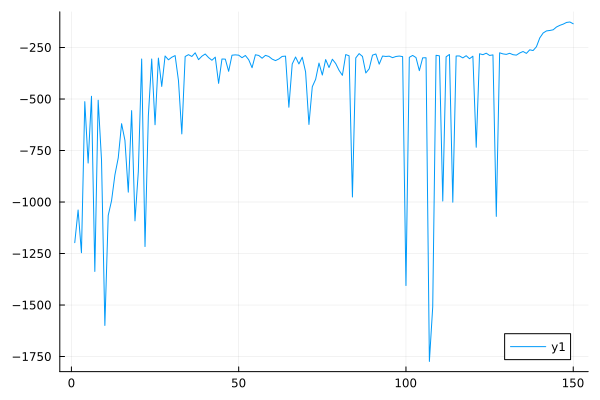

In [5]:
### Plot the stuff
plot(episode_test_reward_hook.rewards)


In [ ]:

close_visualization(); # closes the MeshCat visualization